# Feature extraction and reverse image search

CMPE 256
Winter 2022

Tom Casaletto, Alex Dodd, Sajit Jumani, Albert Mak

This notebook shows the procedure of analyzing a large set of images using pre-trained convolutional networks, extracting feature vectors for each one which represent each image.  Then similarity metrics are used to find the "closest" images to any given query image.

After the analysis is done, we review retrieval tasks and evaluate performance of various implementations of the processing chain.

### Dataset

We need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

This notebook uses an example dataset called [Caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains roughly 9000 images in 101 categories. We remove a couple of the categories for clarity ('Faces_easy', 'Google Background').  One can download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) and unzip it into the `data` folder, or just run the following commands in a terminal from the folder this notebook is in.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
You may use a custom folder of images (which may have subfolders) instead if you wish.

### Primary references
a) https://ml4a.github.io/guides/ReverseImageSearch/

b) https://www.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html

Do some preliminary environment testing.

In [1]:
# Check tensorflow version, may only work on Colab.
#%tensorflow_version 1.x

In [2]:
# Let's look at the GPU processor we're running
#!nvidia-smi

Import all the relevant packages that we'll be using throughout the study.

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

from tqdm import tqdm, tqdm_notebook
from numpy.linalg import norm

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from scipy.spatial import distance
from more_itertools import locate
import matplotlib.patheffects as PathEffects

We first load a previously-trained neural network, that of VGG16, which comes with Keras. If it's the first time loading it, it will automatically download the weights which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which we will later try as well.

In [4]:
model = VGG16(weights='imagenet', include_top=True)

2022-03-09 22:58:42.841288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 22:58:42.866848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 22:58:42.867060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 22:58:42.867390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Let's look at the model summary to see how it's structured.

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). VGG-16 is setup to take a fixed-size (224 x 224 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 4096, 4096, and 1000 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has `None` the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.

In [6]:
# If running on Colab, need to import drive

#from google.colab import drive
#drive.mount('/content/gdrive')

# Or reference local path (change as needed)
images_path = './gdrive/MyDrive/101_ObjectCategories'

# Let's see what categories of pictures are in dataset
# Note:  removed Google background and Faces_easy
!ls $images_path

accordion				   inline_skate
airplanes				   joshua_tree
anchor					   kangaroo
ant					   ketch
barrel					   lamp
bass					   laptop
beaver					   Leopards
binocular				   llama
bonsai					   lobster
brain					   lotus
brontosaurus				   mandolin
buddha					   mayfly
butterfly				   menorah
CalTechFeatures.p			   metrics300_4000.p
CalTechFeatures.p.justPca		   metrics300.p
camera					   metrics.p
cannon					   metronome
car_side				   minaret
ceiling_fan				   Motorbikes
cellphone				   nautilus
chair					   octopus
chandelier				   okapi
cougar_body				   pagoda
cougar_face				   panda
crab					   pigeon
crayfish				   pizza
crocodile				   platypus
crocodile_head				   pyramid
cup					   revolver
dalmatian				   rhino
dollar_bill				   rooster
dolphin					   saxophone
dragonfly				   schooner
electric_guitar				   scissors
elephant				   scorpion
emu					   sea_horse
euphonium				   snoopy
ewer					   soccer_ball
Faces					   stapler
features-caltech101-resnet-closest.pickle  starf

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [7]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Let's load an image in the 'bass' category and take a look at its data vector.

shape of x:  (1, 224, 224, 3)
data type:  float32


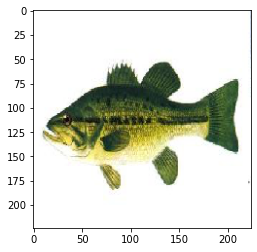

In [8]:
#!ls ./gdrive/MyDrive/101_ObjectCategories/bass
img, x = load_image(images_path + '/bass/image_0005.jpg')
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if `x` has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward `x` through `model` and then use the built-in `decode_predictions` to look up the class names.

In [9]:
# forward the image through the network
predictions = model.predict(x)

# print out the estimates of object type
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

2022-03-09 22:58:45.400716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-09 22:58:45.825430: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


predicted tench with probability 0.261
predicted barracouta with probability 0.245
predicted triceratops with probability 0.184
predicted rock_beauty with probability 0.086
predicted reel with probability 0.025


### Feature extraction

What we have in the `model` variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called `feat_extractor` is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from `feat_extractor` will just be the layer `fc2` from `model`.

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [10]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer `fc2` in VGG16. Let's plot the array as well.

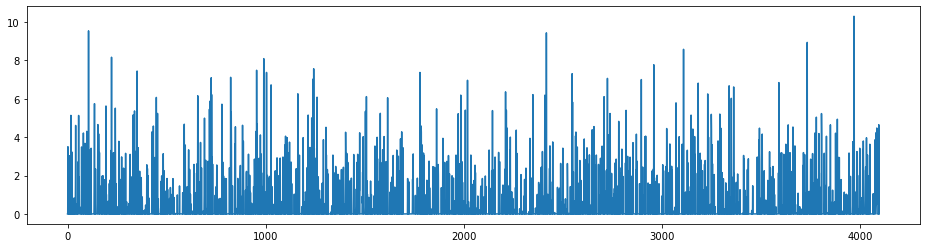

In [11]:
img, x = load_image(images_path + '/bass/image_0005.jpg')
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

Our expectation is that the `fc2` activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the `fc2` activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval. 

In the next cell, we define some helper functions to get and display close images to an input query image.

In [12]:
def getClosestPerImage(images, imageToCategory, pca_feats, N=5):

    # Return the top N *closest* images for each image
    t0 = time.time()

    closestForImagePath = {}
    for i, image_path in enumerate(images):
        # Find category of query image
        queryCategory=imageToCategory[image_path]

        # Get N closest images and store in dictionary
        idx_closest = get_closest_images(i, pca_feats, N)
        closestForImagePath[image_path] = idx_closest

        if i % 500 == 0:
            print("analyzing image %d / %d" % (i, len(images)))

    elap = time.time() - t0;
    print("Total time: %5.4f seconds." % elap)

    return closestForImagePath

def get_closest_images(query_image_idx, pca_feat, num_results=5):
    distances = [ distance.cosine(pca_feat[query_image_idx], feat) for feat in pca_feat ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


Below we either:  1) load the images from scratch, compute some features and store it off to the disk or 2) load previously computed data directly to save some CPU.

In [13]:
# Instead of running the code segments below, if the data is saved out, you can load from pickle
# files 'CalTechFeatures.p' and 'metrics300_4000.p' as shown in this cell

# Following 2 links point to Google drive with shared files:
#https://drive.google.com/file/d/10ZmOOFQpPSQi5nmSd5R0TlNhE9DWumZi/view?usp=sharing
#https://drive.google.com/file/d/1IbyC8h564eJKomlW_ZrU8e945FIiXld8/view?usp=sharing

# Copy these locally and change images_path appropriately

loadFromFile = True
if loadFromFile:
    [images, pca_features, pca, pca_features_full, pcaFull, imageToCategory] = pickle.load(open(images_path + '/CalTechFeatures.p', 'rb'))
    [closestForImagePathFull, closestForImagePath] = pickle.load(open(images_path + '/metrics300_4000.p', 'rb'))
else:
    image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
    max_num_images = 10000

    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    if max_num_images < len(images):
        images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

    print("keeping %d images to analyze" % len(images))

    imageToCategory = {}
    for i in range(len(images)):
        paths = images[i].split('/')
        imageToCategory[images[i]] = paths[4]

    print(len(imageToCategory))

    t0 = time.time()
    tLast = t0

    features = []
    for i, image_path in enumerate(images):
        if i % 500 == 0:
            tNow = time.time()
            elap = tNow-tLast;
            tLast = tNow
            print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        img, x = load_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)

    elap = tNow-t0;
    print('finished extracting features for %d images' % len(images))
    print("Total time: %5.4f seconds." % elap)

    features = np.array(features)
    pca = PCA(n_components=300)
    pca.fit(features)

    # For future comparison, let's look at larger feature vector
    pcaFull = PCA(n_components=4000)
    pcaFull.fit(features)

    pca_features = pca.transform(features)
    print(pca_features.shape)

    pca_features_full = pcaFull.transform(features)
    print(pca_features_full.shape)
    
    # Save to file
    pickle.dump([images, pca_features, pca, pca_features_full, pcaFull, imageToCategory], open(images_path + '/CalTechFeatures.p', 'wb'))

    # Now get closest
    closestForImagePath = getClosestPerImage(images, imageToCategory, pca_features, N=5)
    closestForImagePathFull = getClosestPerImage(images, imageToCategory, pca_features_full, N=5)

    # Save to file
    pickle.dump([closestForImagePathFull, closestForImagePath], open(images_path + '/metrics300_4000.p', 'wb'))

print(dir())
print(len(images))

['In', 'Model', 'NearestNeighbors', 'Out', 'PCA', 'PathEffects', 'ResNet50', 'TSNE', 'VGG16', '_', '_11', '_8', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'closestForImagePath', 'closestForImagePathFull', 'decode_predictions', 'distance', 'exit', 'feat', 'feat_extractor', 'getClosestPerImage', 'get_closest_images', 'get_concatenated_images', 'get_ipython', 'image', 'imageToCategory', 'images', 'images_path', 'img', 'keras', 'loadFromFile', 'load_image', 'locate', 'metrics', 'model', 'norm', 'np', 'os', 'pca', 'pcaFull', 'pca_features', 'pca_features_full', 'pickle', 'plt', 'pred', 'predictions', 'preprocess_input', 'prob', 'quit', 'random', 'time', 'tqdm', 'tqdm_notebook', 'x']
7442


Alone, the activations provide a good representation, but it is a good idea to do one more step before using these as our feature vectors, which is to do a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimensionality of our feature vectors down to 300. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

Thus, PCA reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up.

The next cell will instantiate a `PCA` object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

Now let's see what the PCA version of the feature vector above looks like.

(1, 4096)
(1, 300)
(1, 224, 224, 3)
schooner


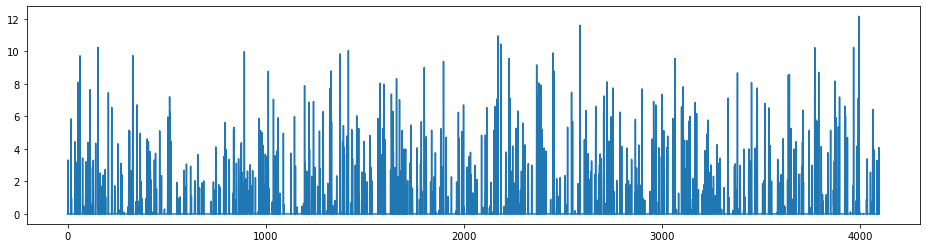

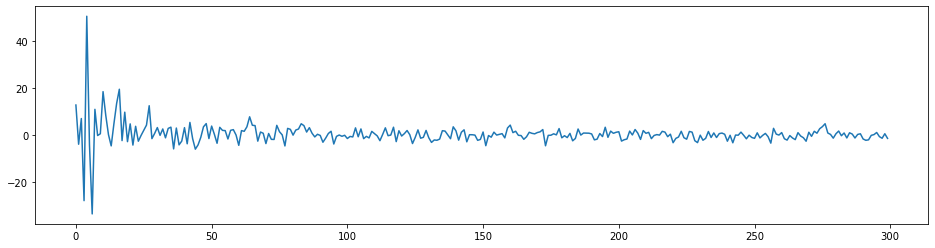

In [14]:
# Compare full feature to PCA version of the feature

thisImage = images[0]
img, x = load_image(thisImage)
this_feat = feat_extractor.predict(x)
print(this_feat.shape)
this_pca = pca.transform(this_feat)
print(this_pca.shape)
print(x.shape)
print(imageToCategory[thisImage])

plt.figure(figsize=(16,4))
plt.plot(this_feat[0])

plt.figure(figsize=(16,4))
plt.plot(this_pca[0])

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Let's pick a random query image.

7442
<class 'dict'>
<class 'list'>
7442
4208
kangaroo


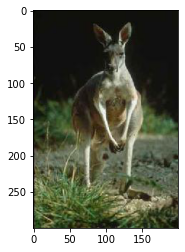

In [15]:
print(len(imageToCategory))
print(type(imageToCategory))
print(type(images))
print(len(images))

# grab a random query image
query_image_idx = int(len(images) * random.random())
print(query_image_idx)
print(imageToCategory[images[query_image_idx]])

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

In [16]:
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [17]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

kangaroo
kangaroo
kangaroo
kangaroo
kangaroo


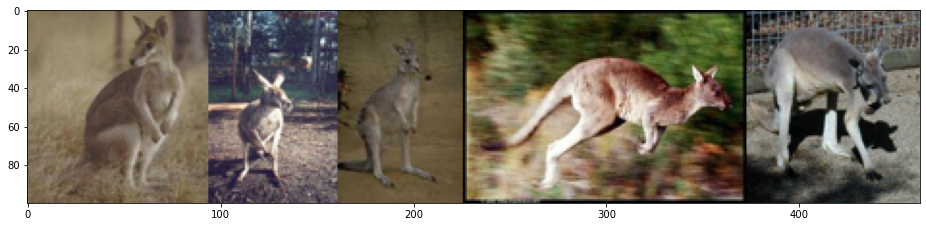

In [18]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    print(imageToCategory[images[idx]])
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


For convenience, we'll automate this process by defining the function `get_closest_images`, which will compute the cosine distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [19]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


So now we can do our lookups like this:

query category= hawksbill
   match category= hawksbill
   match category= hawksbill
   match category= hawksbill
   match category= hawksbill
   match category= hawksbill


Text(0.5, 1.0, 'result images')

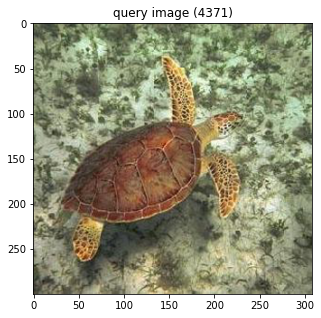

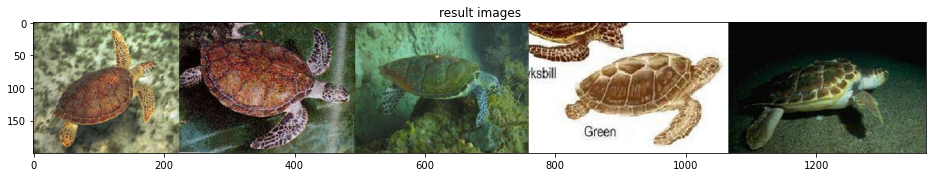

In [20]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
print('query category=', imageToCategory[images[query_image_idx]])
idx_closest = get_closest_images(query_image_idx)
for ii in idx_closest:
  print('   match category=', imageToCategory[images[ii]])

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [21]:
def computeMetrics (y_true, y_pred):

    # Create empty object to hold results
    stats = lambda:0

    stats.mac = metrics.precision_score(y_true, y_pred, average='macro')
    stats.mic = metrics.recall_score(y_true, y_pred, average='micro')
    stats.f1 = metrics.f1_score(y_true, y_pred, average='macro')
    stats.wei = metrics.f1_score(y_true, y_pred, average='weighted')
    stats.beta = metrics.fbeta_score(y_true, y_pred, average='macro', beta=0.5)
    
    return stats

In [22]:
# Compute metrics
y_true = []
y_pred = []

for image_path in images:
    cat1 = imageToCategory[image_path]
    closest = closestForImagePath[image_path]
    for i in closest:
        y_true.append(cat1)
        y_pred.append(imageToCategory[images[i]])

stats = computeMetrics(y_true, y_pred)

print('Precision=', stats.mac)
print('Recall=', stats.mic)
print('F1 score=', stats.f1)
print('Weighted F1=', stats.wei)
print('Beta=', stats.beta)

Precision= 0.8084243887716934
Recall= 0.8543671056167697
F1 score= 0.8007726824806697
Weighted F1= 0.850339299247856
Beta= 0.8043213484962561


Below we loop over each image and find the 5 closest images.  We enter these into a confusion matrix to see which categories have issues regarding classification.

In [23]:
# Create confusion matrix

categories = sorted(set(imageToCategory.values()))
print('num categories=', str(len(categories)))
print('num images=', str(len(closestForImagePath.keys())))

categoryToIdx = {}
idxToCategory = {}
for idx, category in enumerate(categories):
    categoryToIdx[category] = idx
    idxToCategory[idx] = category

print(categoryToIdx)
print(idxToCategory)

totalForCategory = {}
cm = np.zeros([len(categories), len(categories)], dtype=int)
count=0
for image_path in images:
    count += 1
    cat1 = imageToCategory[image_path]
    if cat1 not in totalForCategory:
        #print(str(count), ' ', cat1)
        totalForCategory[cat1] = 0
    totalForCategory[cat1] = totalForCategory[cat1] + 1        
    
    idx1 = categoryToIdx[cat1]
    closest = closestForImagePath[image_path]
    for i in closest:
        cat2 = imageToCategory[images[i]]
        idx2 = categoryToIdx[cat2]
        cm[idx1][idx2] += 1
        
i,j = np.unravel_index(cm.argmax(), cm.shape)
print('Max:', str(i), ' ', str(j), ' ', str(cm[i][j]), ' ', idxToCategory[i])
print(cm)
print(totalForCategory)
for i in range(len(categories)):
    cat = idxToCategory[i]
    print(i, ' ', cat, ' ', totalForCategory[cat])

num categories= 99
num images= 7442
{'Faces': 0, 'Leopards': 1, 'Motorbikes': 2, 'accordion': 3, 'airplanes': 4, 'anchor': 5, 'ant': 6, 'barrel': 7, 'bass': 8, 'beaver': 9, 'binocular': 10, 'bonsai': 11, 'brain': 12, 'brontosaurus': 13, 'buddha': 14, 'butterfly': 15, 'camera': 16, 'cannon': 17, 'car_side': 18, 'ceiling_fan': 19, 'cellphone': 20, 'chair': 21, 'chandelier': 22, 'cougar_body': 23, 'cougar_face': 24, 'crab': 25, 'crocodile': 26, 'crocodile_head': 27, 'cup': 28, 'dalmatian': 29, 'dollar_bill': 30, 'dolphin': 31, 'dragonfly': 32, 'electric_guitar': 33, 'elephant': 34, 'emu': 35, 'euphonium': 36, 'ewer': 37, 'ferry': 38, 'flamingo': 39, 'flamingo_head': 40, 'garfield': 41, 'gerenuk': 42, 'gramophone': 43, 'grand_piano': 44, 'hawksbill': 45, 'headphone': 46, 'hedgehog': 47, 'helicopter': 48, 'ibis': 49, 'inline_skate': 50, 'joshua_tree': 51, 'kangaroo': 52, 'ketch': 53, 'lamp': 54, 'laptop': 55, 'llama': 56, 'lobster': 57, 'lotus': 58, 'mandolin': 59, 'mayfly': 60, 'menorah': 

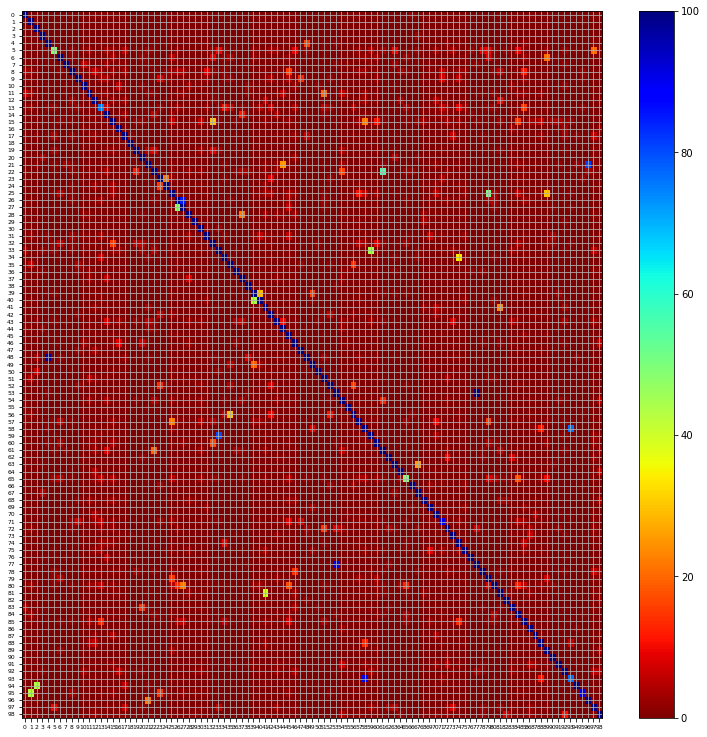

In [24]:
# Plot confusion matrix
N = len(categories)

ticks=np.linspace(0, N-1, num=N)
plt.rcParams["figure.figsize"] = (13,13)

plt.imshow(cm, interpolation='none', aspect='auto', cmap='jet_r', vmin=0, vmax=100)
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)

plt.show()

In [25]:
# Look at categories with highest levels of misclassification
N = len(categories)
threshold = 30
for i in range (N-1):
    for j in range(i+1, N):
        if cm[i][j] > threshold:
            print(str(i), ', ', str(j), ', ', str(cm[i][j]), ' (', categories[i], ', ', categories[j], ')')

21 ,  96 ,  81  ( chair ,  windsor_chair )
22 ,  61 ,  56  ( chandelier ,  menorah )
25 ,  79 ,  50  ( crab ,  scorpion )
26 ,  27 ,  85  ( crocodile ,  crocodile_head )
33 ,  59 ,  45  ( electric_guitar ,  mandolin )
34 ,  74 ,  34  ( elephant ,  rhino )
53 ,  77 ,  128  ( ketch ,  schooner )
58 ,  93 ,  76  ( lotus ,  water_lilly )


Now we shift gears and try another CNN/similarity combination.  Above we used VGG-16 and cosine similarity.  Now we use ResNet-50 and a KNN Euclidean distance metric.

In [26]:
# Switching gears, try a new model (ResNet50)
modelRN = ResNet50(weights='imagenet', include_top=True,
                 input_shape=(224, 224, 3))

def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img).transpose()
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    
    return normalized_features

In [27]:
feat_extractor = Model(inputs=modelRN.input, outputs=modelRN.get_layer("avg_pool").output)
feat_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [28]:
# Loop through all images and extract the feature vector for each image.
# This will take ~4 min with a GPU, much longer without one.

feature_list = []
for i in tqdm_notebook(range(len(images))):
    feature_list.append(extract_features(images[i], feat_extractor))

/tmp/ipykernel_200595/2525650744.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(images))):


  0%|          | 0/7442 [00:00<?, ?it/s]

In [29]:
# Build mapping of image to the category the image is in so we can do scoring.
class_string_ids = []
class_ids = []
classToIdx = {}
idxToClass = {}
pathToClass = {}
idx = 1
for i in range(len(images)):
    paths = images[i].split('/')
    class_string_ids.append(paths[4])
    if paths[4] not in classToIdx:
        classToIdx[paths[4]] = idx
        idxToClass[idx] = paths[4]
        idx += 1

    class_ids.append(classToIdx[paths[4]])
    pathToClass[images[i]] = paths[4]

print(len(class_string_ids))
print(len(class_ids))

7442
7442


Now let's plot out the clusters.  t-SNE is a way to take high dimensional features and plot them in a 2D graph to reveal which clusters are 'close' to each other.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.268s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.206409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.003334
[t-SNE] KL divergence after 1000 iterations: 0.925083
(4000, 2)
<class 'numpy.ndarray'>


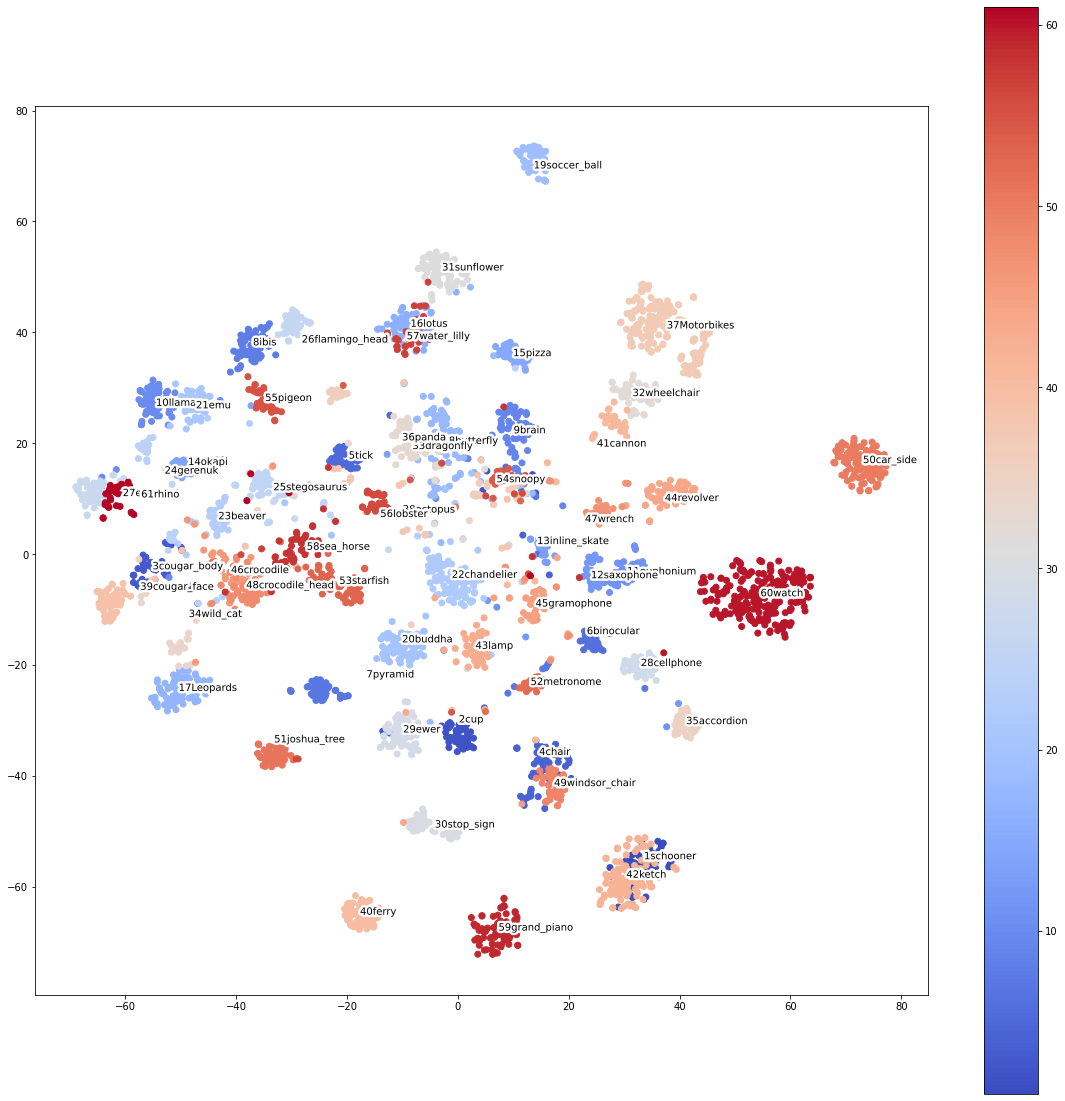

In [30]:
# Use t-SNE to visualize clusters in high dimensional space
# For a good talk on how TSNE works: https://www.youtube.com/watch?v=RJVL80Gg3lA

# Perform PCA over the features
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = images[:4000]

uids = np.unique(selected_class_ids)

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)
print(tsne_results.shape)
print(type(tsne_results))

# Plot a scatter plot from the generated t-SNE results
plt.rcParams["figure.figsize"] = (20,20)
ax = plt.subplot(aspect='equal')

colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c = selected_class_ids, cmap=colormap)
plt.colorbar(scatter_plot)

# We add the labels for each cluster?
txts = []
for id in uids:
    # Position of each label.
    idx = list(locate(selected_class_ids, lambda a: a == id))
    xtext = np.mean(tsne_results[idx,0])
    ytext = np.mean(tsne_results[idx,1])
    txt = ax.text(xtext, ytext, str(id)+idxToClass[id], fontsize=10)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


plt.show()

In [31]:
def get_closest_images_ResNet(imgIdx, features):

    # Let's use KNN to determine our 5 closest images

    #print('Input image:' + images[imgIdx])
    #print('Class:' + class_string_ids[imgIdx])

    # Here use brute force euclicean metric (Q: same as cosine similarity?)
    # TODO: compare different KNNs
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean').fit(features)
    distances, indices = neighbors.kneighbors([features[imgIdx]])
    result = np.zeros([5,1], dtype=int)
    for i in range(1, 6):
        #print(str(distances[0][i]) + ', ' + str(indices[0][i]) + ', ' + str(class_string_ids[indices[0][i]]))
        result[i-1] = indices[0][i]

    return result

In [32]:
# Test out this closest image function
imgIdx=3000
c = get_closest_images_ResNet(imgIdx, feature_list)

print('Input image:' + images[imgIdx])
print('Class of query image:' + class_string_ids[imgIdx])
for i in range(5):
    print('  ', str(class_ids[c[i][0]])+ ', ' + str(class_string_ids[c[i][0]]))

Input image:./gdrive/MyDrive/101_ObjectCategories/crocodile_head/image_0046.jpg
Class of query image:crocodile_head
   48, crocodile_head
   48, crocodile_head
   48, crocodile_head
   48, crocodile_head
   48, crocodile_head


In [33]:
# Compute metrics for ResNet
y_true = []
y_pred = []

#for image_path in images:
for imgIdx in tqdm_notebook(range(len(images))):
    cat1 = imageToCategory[images[imgIdx]]
    closest = get_closest_images_ResNet(imgIdx, feature_list)
    #print(closest.shape)
    #print(type(class_string_ids))
    for i in closest:
        y_true.append(cat1)
        #print(i[0])
        cat2 = class_string_ids[i[0]]
        y_pred.append(cat2)
        #print(cat1 + ' - ', cat2)

statsResNet = computeMetrics(y_true, y_pred)

print('Precision=', statsResNet.mac)
print('Recall=', statsResNet.mic)
print('F1 score=', statsResNet.f1)
print('Weighted F1=', statsResNet.wei)
print('Beta=', statsResNet.beta)

/tmp/ipykernel_200595/4140367154.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for imgIdx in tqdm_notebook(range(len(images))):


  0%|          | 0/7442 [00:00<?, ?it/s]

Precision= 0.823843061633967
Recall= 0.8639344262295082
F1 score= 0.8150198533201636
Weighted F1= 0.8609329692121267
Beta= 0.81940792929971


# Now we can compare the VGG-16/cosine results to the ResNet/KNN-euclidean results

VGG-16 + cosine similarity
* Precision= 0.8084243887716934
* Recall= 0.8543671056167697
* F1 score= 0.8007726824806697
* Weighted F1= 0.850339299247856
* Beta= 0.8043213484962561


ResNet + KNN-Euclidean
* Precision= 0.823843061633967
* Recall= 0.8639344262295082
* F1 score= 0.8150198533201636
* Weighted F1= 0.8609329692121267
* Beta= 0.81940792929971
